In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import statistics
%matplotlib inline

In [2]:
df = pd.read_csv('../../../data/Df with State Rank plus binned columns.csv',index_col="Unnamed: 0")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates,School District,State Rank
0,7129300520,10/13/2014,221900.0,small,minimal,1180,5650,1.0,NaN,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,"(-122.257, 47.5112)",seattle,11-50
1,6414100192,12/9/2014,538000.0,small,minimal,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(-122.319, 47.721000000000004)",seattle,11-50
2,5631500400,2/25/2015,180000.0,small,minimal,770,10000,1.0,0.0,0.0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,"(-122.23299999999999, 47.7379)",northshore,Top_ten
3,2487200875,12/9/2014,604000.0,small,average,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,"(-122.39299999999999, 47.5208)",seattle,11-50
4,1954400510,2/18/2015,510000.0,small,minimal,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,"(-122.045, 47.6168)",lake washington,Top_ten


In [3]:
df = df.drop_duplicates()

In [4]:
df.date = df["date"].map(lambda x: x.split("/")[0])

In [5]:
df['date'] = df['date'].map(lambda x: int(x))

In [6]:
df.waterfront = df.waterfront.replace(np.NaN, 0.0)

In [7]:
df = df.fillna(0.0)

In [8]:
df.columns = df.columns.str.replace(" ", "_")

In [9]:
df.columns = df.columns.str.lower().str.replace(".0", "")

In [10]:
df_corr_price = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corr_price

price            1.000000
sqft_living      0.700673
sqft_above       0.603899
sqft_living15    0.585329
view             0.394476
lat              0.306950
waterfront       0.263315
floors           0.259331
yr_renovated     0.119919
sqft_lot         0.088113
sqft_lot15       0.080797
yr_built         0.049736
zipcode          0.049642
id               0.019255
long             0.018177
date             0.009518
Name: price, dtype: float64

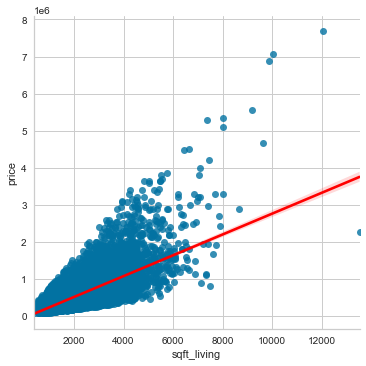

In [11]:
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'red'})
plt.show();

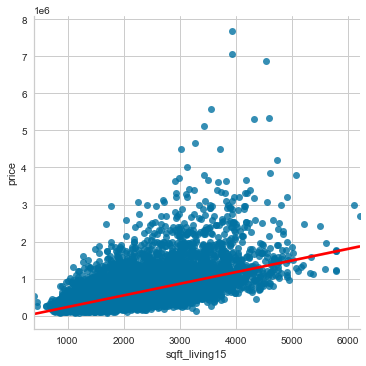

In [12]:
sns.lmplot(x='sqft_living15', y='price', data=df, line_kws={'color': 'red'})
plt.show();

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21234 entries, 0 to 21233
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21234 non-null  int64  
 1   date             21234 non-null  int64  
 2   price            21234 non-null  float64
 3   bedrooms         21234 non-null  object 
 4   bathrooms        21234 non-null  object 
 5   sqft_living      21234 non-null  int64  
 6   sqft_lot         21234 non-null  int64  
 7   floors           21234 non-null  float64
 8   waterfront       21234 non-null  float64
 9   view             21234 non-null  float64
 10  condition        21234 non-null  object 
 11  grade            21234 non-null  object 
 12  sqft_above       21234 non-null  int64  
 13  sqft_basement    21234 non-null  object 
 14  yr_built         21234 non-null  int64  
 15  yr_renovated     21234 non-null  float64
 16  zipcode          21234 non-null  int64  
 17  lat         

In [14]:
dropped_columns = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'sqft_living15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'sqft_basement', 'grade', 'condition', 'view', 'floors',
                  'bedrooms', 'id', 'date', 'price']

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
predictors = df.drop(columns=dropped_columns)
predict= '+'.join(predictors)
f = 'price ~' + predict
model_df = ols(formula=f, data=df).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     4231.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        21:42:41   Log-Likelihood:            -2.9207e+05
No. Observations:               21234   AIC:                         5.842e+05
Df Residuals:                   21225   BIC:                         5.842e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.413e+07    5.4e+05    -63.217      0.000   -3.52e+07   -3.31e+07
bathrooms[T.many]       9.381e+05   5.32e+04     17.632      0.000    8.34e+05    1.04e+06
bathrooms[T.minimal]   -1.034e+05   5659.605    -18.265      0.000   -1.14e+05   -9.23e+04
state_rank[T.51-above]  -922.5169   4139.621     -0.223      0.824   -9036.488    7191.454
state_rank[T.Top_ten]    128.0513   3541.303      0.036      0.971   -6813.171    7069.274
sqft_living              228.7270      3.752     60.954      0.000     221.372     236.082
waterfront              8.728e+05   1.91e+04     45.680      0.000    8.35e+05     9.1e+05
sqft_above                16.4125      3.939      4.166      0.000       8.691      24.134
lat                     7.201e+05   1.13e+04     63.472      0.000    6.98e+05    7.42e+05
==============================================================================
Omnibus:                    13746.579   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           523323.418
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      26.771   Cond. No.                     1.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
dropped_columns_new = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'view', 'floors', 'id', 'date']

In [17]:
df = df.drop(columns=dropped_columns_new)

In [18]:
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.0,47.5112,1340,11-50
1,538000.0,small,minimal,2570,0.0,good,good,2170,400.0,47.7210,1690,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.0,47.7379,2720,Top_ten
3,604000.0,small,average,1960,0.0,very_good,good,1050,910.0,47.5208,1360,11-50
4,510000.0,small,minimal,1680,0.0,good,good,1680,0.0,47.6168,1800,Top_ten


In [19]:
df["sqft_basement"] = df["sqft_basement"].replace("0.0", np.nan)
df["sqft_basement"] = df["sqft_basement"].replace("?", np.nan)
df["sqft_basement"] = df["sqft_basement"].fillna(0.0)
df["sqft_basement"] = df["sqft_basement"].map(lambda x: float(x))

In [20]:
while df["sqft_basement"].loc[df["sqft_basement"] == 0].count() > 0:
    for i in range(0, len(df)):
        if df["sqft_basement"].iloc[i] == 0:
            df["sqft_basement"].iloc[i] = 0.1

C:\Users\Catherine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Lower Price Model

In [32]:
df_low_price_pre = df.loc[df['price']< 300000]
df_low_price_pre

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.1,47.5112,1340,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.1,47.7379,2720,Top_ten
6,257500.0,small,minimal,1715,0.0,good,good,1715,0.1,47.3097,2238,51-above
7,291850.0,small,minimal,1060,0.0,good,good,1060,0.1,47.4095,1650,51-above
8,229500.0,small,minimal,1780,0.0,good,good,1050,730.0,47.5123,1780,51-above
...,...,...,...,...,...,...,...,...,...,...,...,...
21168,295000.0,small,minimal,1230,0.0,good,good,1230,0.1,47.4380,1440,51-above
21195,274800.0,small,minimal,1410,0.0,good,good,1410,0.1,47.5171,1410,11-50
21199,269950.0,small,minimal,2244,0.0,good,good,2244,0.1,47.2606,2077,11-50
21219,288790.0,small,minimal,1290,0.0,good,good,1060,230.0,47.5400,1370,51-above


In [36]:
df_low_price_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 21228
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4374 non-null   float64
 1   bedrooms       4374 non-null   object 
 2   bathrooms      4374 non-null   object 
 3   sqft_living    4374 non-null   int64  
 4   waterfront     4374 non-null   float64
 5   condition      4374 non-null   object 
 6   grade          4374 non-null   object 
 7   sqft_above     4374 non-null   int64  
 8   sqft_basement  4374 non-null   float64
 9   lat            4374 non-null   float64
 10  sqft_living15  4374 non-null   int64  
 11  state_rank     4374 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 604.2+ KB


In [62]:
df_low_price_pre[['bedrooms',"grade",'condition',"bathrooms","state_rank"]]=df_low_price_pre[['bedrooms',"grade",'condition',"bathrooms","state_rank"]].astype('category').copy()
df_low_price_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 21228
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          4374 non-null   float64 
 1   bedrooms       4374 non-null   category
 2   bathrooms      4374 non-null   category
 3   sqft_living    4374 non-null   int64   
 4   waterfront     4374 non-null   float64 
 5   condition      4374 non-null   category
 6   grade          4374 non-null   category
 7   sqft_above     4374 non-null   int64   
 8   sqft_basement  4374 non-null   float64 
 9   lat            4374 non-null   float64 
 10  sqft_living15  4374 non-null   int64   
 11  state_rank     4374 non-null   category
dtypes: category(5), float64(4), int64(3)
memory usage: 455.2 KB


In [60]:
df_low_price_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 21228
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4374 non-null   float64
 1   bedrooms       4374 non-null   object 
 2   bathrooms      4374 non-null   object 
 3   sqft_living    4374 non-null   int64  
 4   waterfront     4374 non-null   float64
 5   condition      4374 non-null   object 
 6   grade          4374 non-null   object 
 7   sqft_above     4374 non-null   int64  
 8   sqft_basement  4374 non-null   float64
 9   lat            4374 non-null   float64
 10  sqft_living15  4374 non-null   int64  
 11  state_rank     4374 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 604.2+ KB


In [72]:
continuous = ["sqft_above", "price",'sqft_living']

categorical = ['bedrooms',"grade",'condition',"bathrooms","state_rank"]

df_log = np.log(df_low_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

    
df_norm = (np.log(df_low_price_pre[continuous]) - np.mean(np.log(df_low_price_pre[continuous])))/np.std(np.log(df_low_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

oe=OrdinalEncoder(categories=[['excessive', 'moderate', 'small'],['very_good',"good", "bad"],['very_good',"good", "bad"],['many', 'average','minimal'],['Top_ten','11-50', '51-above']])
df_ohe=pd.DataFrame(oe.fit_transform(df_low_price_pre[['bedrooms',"grade",'condition',"bathrooms","state_rank"]]))

# enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
# df_ohe=pd.DataFrame(enc.fit_transform(df_low_price_pre[categorical]))
# df_ohe.columns =enc.get_feature_names(['bedrooms',"grade",'condition',"bathrooms","state_rank"])

# df_ohe = pd.get_dummies(df_low_price_pre[categorical], columns=categorical, drop_first = True)
df_low_price =df_norm.join(df_ohe, how="inner")
# df_low_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_low_price = pd.concat([df_final1,df_low_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [73]:
display(df_norm.isna().sum(),df_ohe.isna().sum(),df_low_price.isna().sum())

sqft_above_log     0
price_log          0
sqft_living_log    0
dtype: int64

0    0
1    0
2    0
3    0
4    0
dtype: int64

sqft_above_log     0
price_log          0
sqft_living_log    0
0                  0
1                  0
2                  0
3                  0
4                  0
dtype: int64

In [74]:
df_low_price.tail(25)

,sqft_above_log,price_log,sqft_living_log,0,1,2,3,4
4245,-0.352895,-1.296646,-0.640213,2.0,1.0,1.0,2.0,0.0
4246,-0.414128,-0.402234,0.542972,2.0,1.0,1.0,2.0,2.0
4249,0.152844,-1.165447,-0.169485,2.0,1.0,1.0,2.0,2.0
4251,-0.147016,-0.914701,-0.448587,2.0,1.0,1.0,2.0,1.0
4257,-0.949208,-1.921453,-1.195246,2.0,1.0,1.0,2.0,1.0
4258,0.073699,-0.314933,-0.243151,2.0,1.0,1.0,2.0,1.0
4260,0.403873,0.274020,1.498615,2.0,1.0,1.0,2.0,0.0
4273,0.726327,-1.598754,0.364298,2.0,1.0,1.0,2.0,0.0
4278,-0.476505,0.312061,-0.755267,2.0,1.0,1.0,2.0,1.0
4287,1.836602,1.006803,1.397712,2.0,1.0,1.0,2.0,0.0


In [75]:
X_low = df_low_price.drop(columns=['price_log'], axis=1) 
y_low = df_low_price[['price_log']]
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, random_state=50, test_size=.25)

In [76]:
X_train_low

,sqft_above_log,sqft_living_log,0,1,2,3,4
1908,2.764997,2.261838,2.0,1.0,1.0,2.0,1.0
2184,1.488499,1.073707,2.0,1.0,0.0,2.0,1.0
1126,-0.604871,-0.874746,2.0,2.0,1.0,2.0,0.0
2035,1.080121,0.693600,2.0,1.0,0.0,2.0,2.0
675,-0.772601,0.196360,2.0,2.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...
1237,0.126670,-0.193847,2.0,2.0,1.0,2.0,2.0
465,0.918290,0.542972,2.0,1.0,1.0,2.0,1.0
4141,0.230155,-0.097526,2.0,2.0,0.0,2.0,1.0
2201,0.834333,0.464827,2.0,1.0,0.0,2.0,0.0


In [77]:
f = y_train_low, X_train_low
model_low = ols(formula=f, data=X_train_low).fit()
model_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.215
Model:                            OLS   Adj. R-squared (uncentered):              0.207
Method:                 Least Squares   F-statistic:                              27.58
Date:                Thu, 01 Jul 2021   Prob (F-statistic):                    1.35e-33
Time:                        22:01:18   Log-Likelihood:                         -930.25
No. Observations:                 713   AIC:                                      1874.
Df Residuals:                     706   BIC:                                      1906.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_above_log      0.0322      0.057      0.565      0.573      -0.080       0.144
sqft_living_log     0.4373      0.056      7.761      0.000       0.327       0.548
0                  -0.1256      0.195     -0.644      0.520      -0.508       0.257
1                   0.0347      0.071      0.486      0.627      -0.105       0.175
2                   0.0626      0.064      0.971      0.332      -0.064       0.189
3                   0.0311      0.195      0.159      0.874      -0.352       0.414
4                   0.0382      0.047      0.810      0.418      -0.054       0.131
==============================================================================
Omnibus:                       90.048   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.578
Skew:                          -0.825   Prob(JB):                     1.48e-32
Kurtosis:                       4.488   Cond. No.                         26.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
df_low_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log          1.000000
sqft_living_log    0.437888
sqft_above_log     0.351663
4                  0.047681
3                  0.025228
1                  0.020836
0                  0.019080
2                  0.005755
Name: price_log, dtype: float64

In [104]:
linreg_low = LinearRegression()
linreg_low.fit(X_train_low, y_train_low)

predicted_y_low = linreg_low.predict(X_test_low) 

linreg_low.score(X_test_low, y_test_low)

0.11486542870474126

In [80]:
lr_low = LinearRegression()

In [81]:
lr_low.fit(X_train_low, y_train_low)

LinearRegression()

In [82]:
from sklearn.model_selection import KFold

folds = KFold(10, shuffle = True)
train_train_scores = []
train_test_scores = []
train_train_rmse = []
train_test_rmse = []
for train_ind, test_ind in folds.split(X_train_low):
    X_train_low_train = X_train_low.iloc[train_ind]
    X_train_low_test = X_train_low.iloc[test_ind]
    y_train_low_train = y_train_low.iloc[train_ind]
    y_train_low_test = y_train_low.iloc[test_ind]
    linreg_low1 = LinearRegression()
    linreg_low1.fit(X_train_low_train, y_train_low_train)
    train_train_scores.append(linreg_low1.score(X_train_low_train, y_train_low_train))
    train_test_scores.append(linreg_low1.score(X_train_low_test, y_train_low_test))
    train_train_rmse.append(np.sqrt(mse(y_train_low_train, linreg_low1.predict(X_train_low_train))))
    train_test_rmse.append(np.sqrt(mse(y_train_low_test, linreg_low1.predict(X_train_low_test))))
    

In [100]:
train_test_scores

[0.23637522156068946,
 0.19765727595808025,
 0.20548842855681437,
 0.2609667303537745,
 0.14270006271362745,
 0.3260176923716742,
 0.054635797979627476,
 0.1978451259774322,
 0.09292999751821684,
 0.16750658524329576]

In [84]:
train_train_scores

[0.21011993407794527,
 0.21471251067067998,
 0.21433457151627267,
 0.20342253229963325,
 0.2206522635466276,
 0.19891605731473683,
 0.22346754224530319,
 0.21533741250049476,
 0.22947610639727767,
 0.2172962875764506]

In [85]:
train_train_rmse

[0.8965644341995677,
 0.9035134887016248,
 0.8920589911517938,
 0.8694525020605324,
 0.8900713150282465,
 0.894264900240048,
 0.9021346664755081,
 0.8884349021631972,
 0.8733186869364132,
 0.8913482786481045]

In [86]:
train_test_rmse

[0.8445374190869988,
 0.7695383277824711,
 0.8803595317214786,
 1.0679506075528364,
 0.899555178165827,
 0.8637769654518546,
 0.788315397308969,
 0.9130252730691657,
 1.0368726405500748,
 0.8913092119156245]

In [102]:
display(linreg_low.score(X_test_low, y_test_low),statistics.mean(train_train_scores),statistics.mean(train_test_scores))

0.11486542870474126

0.21477352181454218

0.18821229182332325

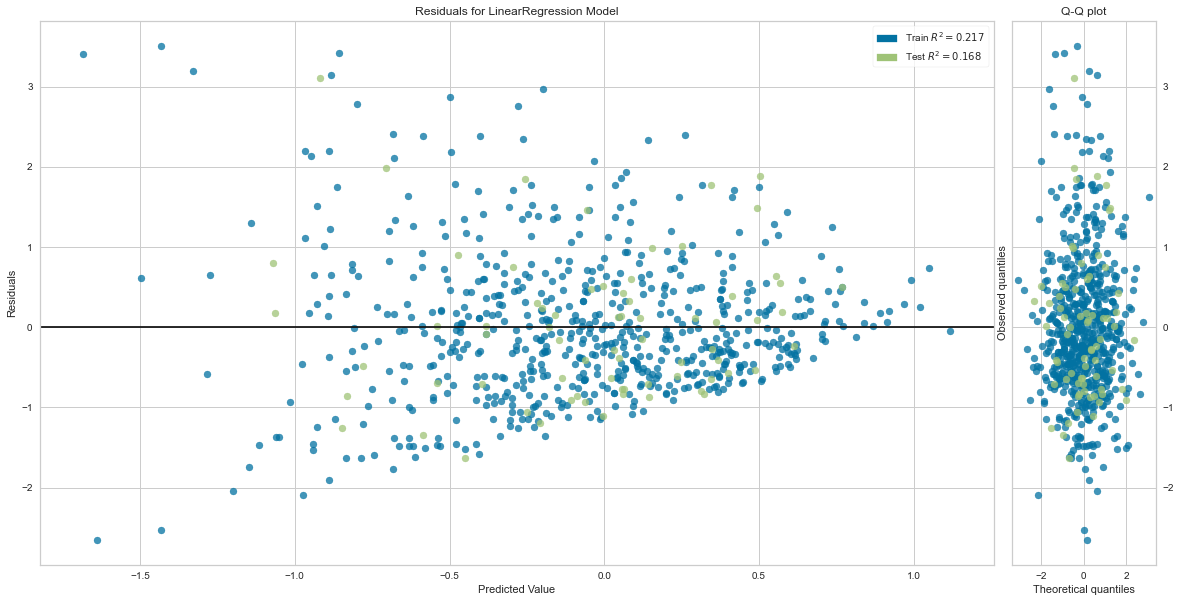

In [87]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(linreg_low1, hist=False, qqplot=True)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_train_low_test, y_train_low_test)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower plus QQ plot.png', dpi=300)

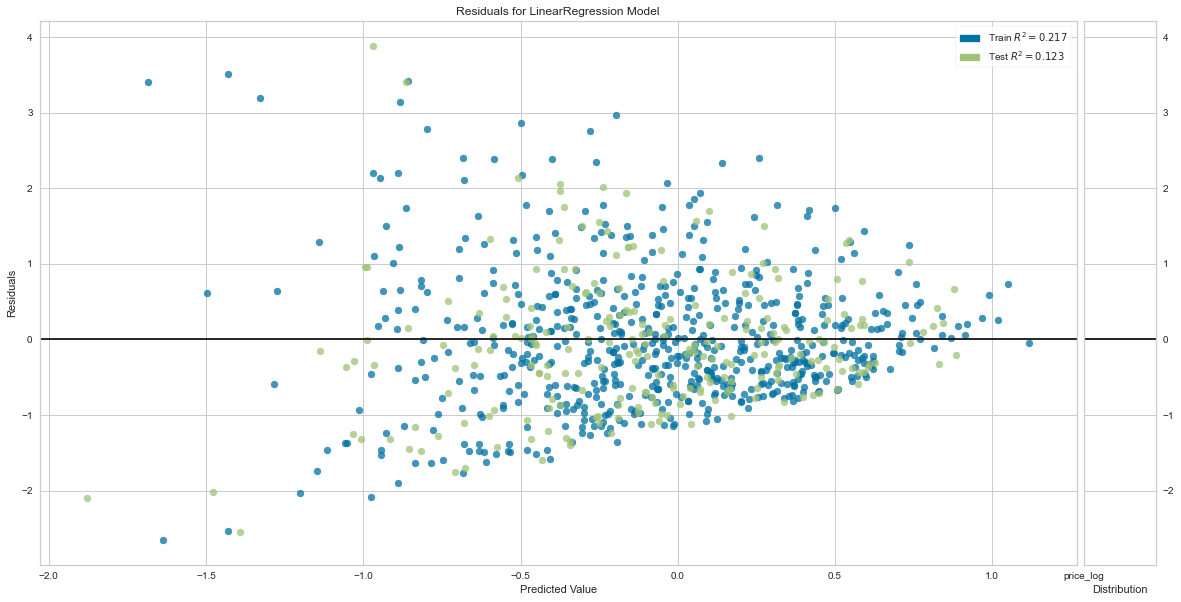

In [88]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(linreg_low1)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_test_low, y_test_low)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower Price.png', dpi=300)

## Middle Price Model

In [ ]:
df_middle_price_pre = df.loc[(300000 <= df['price']) & (df['price'] < 650000)]
df_middle_price_pre.head()

In [ ]:
df_middle_price_pre.columns

In [ ]:
continuous = ["sqft_above", "price", "sqft_living15","sqft_living","lat"]

categorical = ['bathrooms',"grade","state_rank"]

df_log = np.log(df_middle_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df[continuous]]

    
df_norm = (np.log(df_middle_price_pre[continuous]) - np.mean(np.log(df_middle_price_pre[continuous])))/np.std(np.log(df_middle_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)

df_middle_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_middle_price = pd.concat([df_final1,df_middle_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [ ]:
df_middle_price.columns

In [ ]:
X_middle = df_middle_price.drop(columns=['price_log'], axis=1) 
y_middle = df_middle_price[['price_log']]
X_train_middle, X_test_middle, y_train_middle, y_test_middle = train_test_split(X_middle, y_middle, random_state=50, test_size=.25)

In [ ]:
f = y_train_middle, X_train_middle
model_mid = ols(formula=f, data=X_train_middle).fit()
model_mid.summary()

In [ ]:
df_middle_price.corr()['price_log'].map(abs).sort_values(ascending=False)

In [ ]:
linreg_mid = LinearRegression()
linreg_mid.fit(X_train_middle, y_train_middle)

predicted_y_middle = linreg_mid.predict(X_test_middle) 

linreg_mid.score(X_test_middle, y_test_middle)

In [ ]:
lr_middle = LinearRegression()

In [ ]:
lr_middle.fit(X_train_middle, y_train_middle)

In [ ]:
folds2 = KFold(10, shuffle = True)
train_train_scores_mid = []
train_test_scores_mid = []
train_train_rmse_mid = []
train_test_rmse_mid = []
for train_ind_mid, test_ind_mid in folds2.split(X_train_middle):
    X_train_mid_train = X_train_middle.iloc[train_ind_mid]
    X_train_mid_test = X_train_middle.iloc[test_ind_mid]
    y_train_mid_train = y_train_middle.iloc[train_ind_mid]
    y_train_mid_test = y_train_middle.iloc[test_ind_mid]
    linreg_mid = LinearRegression()
    linreg_mid.fit(X_train_mid_train, y_train_mid_train)
    train_train_scores_mid.append(linreg_mid.score(X_train_mid_train, y_train_mid_train))
    train_test_scores_mid.append(linreg_mid.score(X_train_mid_test, y_train_mid_test))
    train_train_rmse_mid.append(np.sqrt(mse(y_train_mid_train, linreg_mid.predict(X_train_mid_train))))
    train_test_rmse_mid.append(np.sqrt(mse(y_train_mid_test, linreg_mid.predict(X_train_mid_test))))

In [ ]:
train_train_scores_mid

In [ ]:
train_test_scores_mid

In [ ]:
train_train_rmse_mid

In [ ]:
train_test_rmse_mid

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(linreg_mid, hist=False, qqplot=True)
visualizer_middle.fit(X_train_mid_train, y_train_mid_train)
visualizer_middle.score(X_train_mid_test, y_train_mid_test)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price plus QQ plot.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(linreg_mid, hist=True)
visualizer_middle.fit(X_train_mid_train, y_train_mid_train)
visualizer_middle.score(X_test_middle, y_test_middle)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price.png', dpi=300)

## Higher Price Model

In [ ]:
df_higher_price = df.loc[df['price']>= 650000]
df_higher_price

In [ ]:
df_higher_price.columns

In [ ]:
continuous = ["sqft_above", "price", "sqft_basement","sqft_living"]

categorical = ['bathrooms',"grade","state_rank", "waterfront"]

df_log = np.log(df_middle_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df[continuous]]

    
df_norm = (np.log(df_middle_price_pre[continuous]) - np.mean(np.log(df_middle_price_pre[continuous])))/np.std(np.log(df_middle_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)

df_higher_price = pd.concat([df_norm, df_ohe], axis = 1)

In [ ]:
df_higher_price.columns

In [ ]:
X_higher = df_higher_price.drop(columns=['price_log'], axis=1) 
y_higher = df_higher_price[['price_log']]
X_train_higher, X_test_higher, y_train_higher, y_test_higher = train_test_split(X_higher, y_higher, random_state=50, test_size=.25)

In [ ]:
f = y_train_higher, X_train_higher
model_high = ols(formula=f, data=X_train_higher).fit()
model_high.summary()

In [ ]:
df_higher_price.corr()['price_log'].map(abs).sort_values(ascending=False)

In [ ]:
linreg_high = LinearRegression()
linreg_high.fit(X_train_higher, y_train_higher)

predicted_y_higher = linreg_high.predict(X_test_higher) 

linreg_high.score(X_test_higher, y_test_higher)

In [ ]:
lr_higher = LinearRegression()

In [ ]:
lr_higher.fit(X_train_higher, y_train_higher)

In [ ]:
folds3 = KFold(10, shuffle = True)
train_train_scores_high = []
train_test_scores_high = []
train_train_rmse_high = []
train_test_rmse_high = []
for train_ind_high, test_ind_high in folds3.split(X_train_higher):
    X_train_high_train = X_train_higher.iloc[train_ind_high]
    X_train_high_test = X_train_higher.iloc[test_ind_high]
    y_train_high_train = y_train_higher.iloc[train_ind_high]
    y_train_high_test = y_train_higher.iloc[test_ind_high]
    linreg_high = LinearRegression()
    linreg_high.fit(X_train_high_train, y_train_high_train)
    train_train_scores_high.append(linreg_high.score(X_train_high_train, y_train_high_train))
    train_test_scores_high.append(linreg_high.score(X_train_high_test, y_train_high_test))
    train_train_rmse_high.append(np.sqrt(mse(y_train_high_train, linreg_high.predict(X_train_high_train))))
    train_test_rmse_high.append(np.sqrt(mse(y_train_high_test, linreg_high.predict(X_train_high_test))))

In [ ]:
train_train_scores_high

In [ ]:
train_test_scores_high

In [ ]:
train_train_rmse_high

In [ ]:
train_test_rmse_high

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(linreg_high, hist=False, qqplot=True)
visualizer_higher.fit(X_train_high_train, y_train_high_train)
visualizer_higher.score(X_train_high_test, y_train_high_test)
visualizer_higher.show();
# plt.savefig('Linear Regression Model Higher Price plus QQ plot.png',dpi=300);

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(linreg_high)
visualizer_higher.fit(X_train_high_train, y_train_high_train)
visualizer_higher.score(X_test_higher, y_test_higher)
visualizer_higher.show();
# plt.savefig('Linear Regression Model High Price.png')